# Fake News Detection

## 1. Data preparation

### Importing Libraries

In [1]:
import re
import string

import pandas as pd
import numpy as np
from langdetect import detect
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
import tensorflow as tf
from keras.utils import to_categorical

### Importing Dataset

In [2]:
df_whole = pd.read_csv("PreProcessedData.csv")

### Familiarization with the data

In [3]:
df_whole.head()

,index,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [4]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69045 entries, 0 to 69044
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         69045 non-null  int64 
 1   title         68365 non-null  object
 2   text          68978 non-null  object
 3   Ground Label  69045 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


### We check the percentage of true articles

In [5]:
len(df_whole[df_whole['Ground Label']=="true"])/len(df_whole)

0.3893982185531175

### We divide the dataset into a training set and a validation set

In [6]:
df, valid = train_test_split(
    df_whole, stratify=df_whole["Ground Label"], test_size=0.3, random_state=42
)

In [7]:
valid.head()

,index,title,text,Ground Label
7765,7765,Donald Trump Just Took Credit For Christmas A...,Americans have been spending well over $2 tril...,fake
28281,28281,"Australia Successfully Reformed Gun Laws, Why ...",An Embattled Pharmaceutical Company That Sells...,fake
41152,41152,WWN’s Horoscopes,aries 21 March – 20 April \r\nLook at that stu...,fake
22071,22071,Something big is underway on all fronts: “With...,VIDEOS Something big is underway on all fronts...,fake
68977,68977,U.S. Intelligence Says Details Of Russian Dos...,When the bombshell dossier exposing Donald Tru...,fake


In [8]:
valid.to_csv('walidacja.csv', index=False)

In [9]:
df, test = train_test_split(
    df, stratify=df["Ground Label"], test_size=0.3, random_state=42
)

In [10]:
test.head()

,index,title,text,Ground Label
40542,40542,Adele: No permission given to political campai...,(Reuters) - British singer Adele made clear on...,true
38393,38393,BORDER COLLAPSE AMID ELECTION,"by DML DAILY / November 4, 2016 / IMMIGRATION ...",fake
34334,34334,Tim Allen: Hollywood Bullies Trump Supporters,"On The Kelly File Monday, actor Tim Allen disc...",fake
21406,21406,North Korea sentences South Korean reporters t...,SEOUL (Reuters) - A North Korean court sentenc...,true
60696,60696,ESPN Just Fired Curt Schilling For This Despi...,ESPN just made an amazing stand against bigotr...,fake


In [11]:
test.to_csv('test.csv', index=False)

# 2. Data preprocessing

### We transform the 'Ground Label' column, containing 'fake' or 'true' strings to a 'class' column with binary values, 0 for 'fake' news and 1 for 'true' news

In [12]:
#fake, true -> 0, 1
df['class']=np.where(df['Ground Label']=='fake', 0, 1)
df = df.drop('Ground Label', axis=1)
df = df.drop('index', axis=1)


### We fill in the empty values in the 'text' and 'title' columns

In [13]:
df["text"] = df["text"].fillna("")
df["title"] = df["title"].fillna("")

### After checking that only 6% of articles without content and 0% of articles without a title are true, we can delete them

In [14]:
print("True: ", df[df["text"]==""]["class"].sum(), "   All: ", len(df[df["text"]==""]["class"]))
print("True: ", df[df["title"]==""]["class"].sum(), "   All: ", len(df[df["title"]==""]["class"]))
df = df.drop(df[df["text"]==""].index)
df = df.drop(df[df["title"]==""].index)

True:  2    All:  32
True:  0    All:  326


### Let's check how the number of links in the text correlates with the truthfulness of articles

In [15]:
def contains_link(text):
    regex = r'https?://\S+|www\.\S+'
    url = re.findall(regex, text)
    return len(url)

In [16]:
df["links"] = df["text"].apply(contains_link)
print(df[df["links"]>0]["class"].sum(), len(df[df["links"]>0]))
print(df[df["links"]>1]["class"].sum(), len(df[df["links"]>1]))
print(df[df["links"]>2]["class"].sum(), len(df[df["links"]>2]))
print(df[df["links"]>3]["class"].sum(), len(df[df["links"]>3]))

41 3047
3 856
1 395
0 191


### Let's check how the number of question marks and exclamation marks in the text correlates with the truthfulness of articles

1593 10909
674 6756


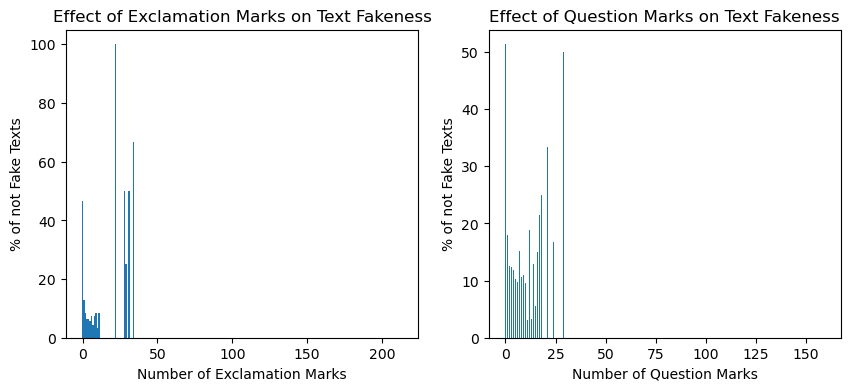

In [17]:
df["question_marks"] = df["text"].apply(lambda x: x.count("?"))
df["exclamation_marks"] = df["text"].apply(lambda x: x.count("!"))
print(df[df["question_marks"]>0]["class"].sum(), len(df[df["question_marks"]>0]))
print(df[df["exclamation_marks"]>0]["class"].sum(), len(df[df["exclamation_marks"]>0]))

groupedq = df.groupby("question_marks")["class"].mean() * 100
groupede = df.groupby("exclamation_marks")["class"].mean() * 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].bar(groupede.index, groupede.values)
ax[0].set_xlabel("Number of Exclamation Marks")
ax[0].set_ylabel("% of not Fake Texts")
ax[0].set_title("Effect of Exclamation Marks on Text Fakeness")

ax[1].bar(groupedq.index, groupedq.values)
ax[1].set_xlabel("Number of Question Marks")
ax[1].set_ylabel("% of not Fake Texts")
ax[1].set_title("Effect of Question Marks on Text Fakeness")

plt.show()

### We can see that the higher number of links, question marks, or exclamation marks, the higher chance that the text is fake. To consider that information in our model we add extra columns with their number.

### We create clean function that cleans our text

In [18]:
def clean(text):
    #usuwa wszystko w kwadratowych nawiasach
    text = re.sub('\[.*?\]', '', text)
    #usuwa wszystkie znaki niebędące literami ani cyframi
    text = re.sub("\\W"," ",text)
    #usuwa linki
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #usuwa tagi
    text = re.sub('<.*?>+', '', text)
    #usuwa znaki interpunkcyjne
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #usuwa entery
    text = re.sub('\n', '', text)
    #usuwa ciągi znaków zawierające cyfry
    text = re.sub('\w*\d\w*', '', text)
    #usuwa słowa jednoliterowe
    text = re.sub(r'\b\w\b', '', text)
    #usuwa puste spacje
    text = re.sub(r'\s+', ' ', text)
    return text

### We apply the clean function to columns "text" and "title"

In [19]:
#Aplikujemy funkcję czyszczącą tekst
df["text"] = df["text"].apply(clean)
df["title"] = df["title"].apply(clean)

### Let's check how the frequency of capitalization of letters in the title affects the truthfulness of the article

In [20]:
def count_capital_letters(text):
    count = 0
    for c in re.sub(r'\s+', '', text):
        if c.isupper():
            count += 1
    return count/max(len(text),1)

In [21]:
df["capital_letters"] = df["text"].apply(count_capital_letters)
print(df[df["capital_letters"]>0.1]["class"].sum(), len(df[df["capital_letters"]>0.1]["class"]))
print(df[df["capital_letters"]>0.2]["class"].sum(), len(df[df["capital_letters"]>0.2]["class"]))

70 1251
3 147


### We transform columns to lowercase

In [22]:
df["text"] = df["text"].apply(lambda x: x.lower())
df["title"] = df["title"].apply(lambda x: x.lower())

### Let's check how the number of words correlates with the truthfulness of articles

416 2232


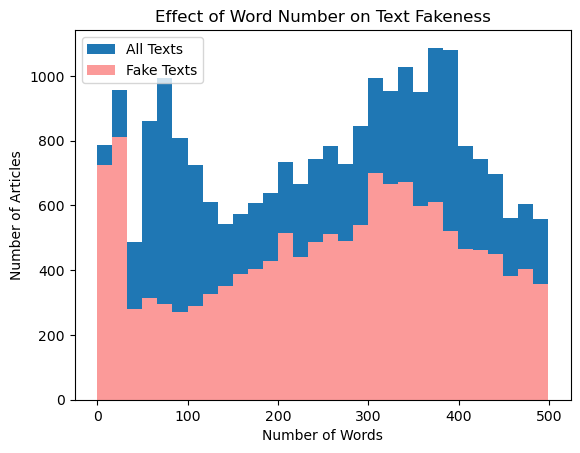

In [23]:
df["num_words"] = df["text"].apply(lambda x: len(x.split()))
print(df[df["num_words"]<50]["class"].sum(), len(df[df["num_words"]<50]))

groupednum = df[df["num_words"]<500].groupby("num_words")["class"].mean() * 100

fig, ax = plt.subplots()

ax.hist(df[df["num_words"]<500]["num_words"], bins=30, label="All Texts")
ax.hist(df[(df["num_words"]<500) & (df["class"] == 0)]["num_words"], bins=30, color="#fb9a99", label="Fake Texts")
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Articles")
ax.set_title("Effect of Word Number on Text Fakeness")
ax.legend()

plt.show()

### After the initial analysis, we noticed that all articles not written in English were not true. Therefore, when building a model based on our dataset, it will predict that articles written in languages other than English are not true. As a result, we decided to analyze only news articles written in English. To remove others later on, we created a function that detects the language.

In [24]:
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [25]:
df["language"] = (df["text"]+df["title"]).apply(detect_language)
len(df[df["language"]!="en"])

306

In [27]:
df = df.drop(df[df["language"] != "en"].index)

In [28]:
df.head()

,title,text,class,links,question_marks,exclamation_marks,capital_letters,num_words,language
38599,hillary puts trump to shame with powerful res...,after white nationalist rally in charlottesvil...,0,0,0,1,0.031216,310,en
29999,exclusive clinton op ed ll look for common ground,why you should vote for me in january america ...,1,0,1,0,0.021406,683,en
66335,spy scandals globalism and the betrayal of ame...,articles of the bound spy scandals globalism ...,0,0,1,0,0.041473,900,en
15786,trump slams canada by using example border st...,it can easily be said that donald trump doesn ...,0,0,2,3,0.032641,293,en
46420,breaking america was punked no direct ties bet...,could this be the biggest fake news story of a...,0,1,1,0,0.053229,223,en


In [29]:
unknown_mask = df["language"] == "unknown"
df.loc[unknown_mask, "language"] = df.loc[unknown_mask, "title"].apply(detect_language)

df=df[df.language=="en"].loc[:, df.columns != "language"]

In [30]:
df.head()

,title,text,class,links,question_marks,exclamation_marks,capital_letters,num_words
38599,hillary puts trump to shame with powerful res...,after white nationalist rally in charlottesvil...,0,0,0,1,0.031216,310
29999,exclusive clinton op ed ll look for common ground,why you should vote for me in january america ...,1,0,1,0,0.021406,683
66335,spy scandals globalism and the betrayal of ame...,articles of the bound spy scandals globalism ...,0,0,1,0,0.041473,900
15786,trump slams canada by using example border st...,it can easily be said that donald trump doesn ...,0,0,2,3,0.032641,293
46420,breaking america was punked no direct ties bet...,could this be the biggest fake news story of a...,0,1,1,0,0.053229,223


### Next, to extract valuable information from the text and improve the quality of the model, we lemmatize the text and remove the so-called stop words

### Lemmatization involves reducing different forms of a word to its basic form, or lemma. This way, we won't analyze words like car, cars, and car's separately, but rather identify them with their lemma - car.

In [31]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [32]:
df[["text", "title"]] = df[["text", "title"]].apply(lambda x: x.apply(lemmatize_text))

### Stop words are words that are very common in the language, but do not carry much meaning and can introduce noise into text analysis. Examples include and, but, the.

In [33]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [34]:
df[["text", "title"]] = df[["text", "title"]].apply(lambda x: x.apply(remove_stop_words))

### We save the data to csv

In [31]:
df.to_csv('processed_Data.csv', index=False)

# 3. Building model

### Loading data from the previous subpoint.

In [35]:
df = pd.read_csv("processed_Data.csv")
test = pd.read_csv("test.csv")
df["text"] = df["text"].fillna("")
df["title"] = df["title"].fillna("")

### We convert the preprocessed text into numerical vectors using the TF-IDF method.

In [36]:
vectorizerText = TfidfVectorizer()
vectorizerTitle = TfidfVectorizer()

vectorizedText = vectorizerText.fit_transform(df["text"])
vectorizedTitle = vectorizerTitle.fit_transform(df["title"])


### We scale added columns

In [37]:
scaler = MinMaxScaler()
df_part = df[["num_words","exclamation_marks","question_marks","links", "capital_letters"]]
scaled_df = pd.DataFrame(scaler.fit_transform(df_part), columns=df_part.columns)
scaled_df.head()

,num_words,exclamation_marks,question_marks,links,capital_letters
0,0.015574,0.004695,0.000000,0.000000,0.036766
1,0.034313,0.000000,0.006289,0.000000,0.025211
2,0.045215,0.000000,0.006289,0.000000,0.048846
3,0.014720,0.014085,0.012579,0.000000,0.038444
4,0.011203,0.000000,0.006289,0.029412,0.062692


### We prepare the training data. We will use content, title and features we extracted in the preprocessing to train one model and we will use only content and title to train the other model. We can then compare if our preprocessing had some impact on the results.

In [38]:
Xv_train= hstack([vectorizedTitle, vectorizedText,scipy.sparse.csr_matrix(scaled_df[["links","question_marks","exclamation_marks","capital_letters","num_words"]].values)])
Xv_train2 = hstack([vectorizedTitle, vectorizedText])
y_train = df['class']

### We preprocess the test data

In [39]:
test['class']=np.where(test['Ground Label']=='fake', 0, 1)
test["text"] = test["text"].fillna("")
test["title"] = test["title"].fillna("")
test["links"] = test["text"].apply(contains_link)
test["question_marks"] = test["text"].apply(lambda x: x.count("?"))
test["exclamation_marks"] = test["text"].apply(lambda x: x.count("!"))
test["text"] = test["text"].apply(clean)
test["title"] = test["title"].apply(clean)
test["capital_letters"] = test["text"].apply(count_capital_letters)
test["text"] = test["text"].apply(lambda x: x.lower())
test["title"] = test["title"].apply(lambda x: x.lower())
test["num_words"] = test["text"].apply(lambda x: len(x.split()))
test[["text", "title"]] = test[["text", "title"]].apply(lambda x: x.apply(lemmatize_text))
test[["text", "title"]] = test[["text", "title"]].apply(lambda x: x.apply(remove_stop_words))
test.head()

,index,title,text,Ground Label,class,links,question_marks,exclamation_marks,capital_letters,num_words
0,40542,adele permission given political campaign use ...,reuters british singer adele made clear monday...,true,1,0,0,0,0.040161,215
1,38393,border collapse amid election,dml daily november immigration illegal alien f...,fake,0,0,0,0,0.039648,278
2,34334,tim allen hollywood bully trump supporter,kelly file monday actor tim allen discussed hy...,fake,0,0,0,0,0.043478,39
3,21406,north korea sentence south korean reporter dea...,seoul reuters north korean court sentenced two...,true,1,0,0,0,0.044112,436
4,60696,espn fired curt schilling despicable facebook ...,espn made amazing stand bigotry airwave firing...,fake,0,0,4,1,0.038238,539


### We vectorize the test data using the previously created TF-IDF model.

In [40]:
vectorizedTextTest = vectorizerText.transform(test["text"])
vectorizedTitleTest = vectorizerTitle.transform(test["title"])

### We scale the created column in the test data.

In [41]:
test_part = test[["num_words","exclamation_marks","question_marks","links", "capital_letters"]]
scaled_test = pd.DataFrame(scaler.fit_transform(test_part), columns=test_part.columns)

### We prepare the test data

In [42]:
test['class']=np.where(test['Ground Label']=='fake', 0, 1)
Xv_test= hstack([vectorizedTitleTest, vectorizedTextTest,scipy.sparse.csr_matrix(scaled_test[["links","question_marks","exclamation_marks","capital_letters","num_words"]].values)])
Xv_test2 = hstack([vectorizedTitleTest, vectorizedTextTest])
y_test = test['class']

### We create and test a logistic regression model.

In [43]:
LR = LogisticRegression()
LR.fit(Xv_train, y_train)
print(LR.score(Xv_test, y_test))

0.9533793103448276


### We create and test a second logistic regression model.

In [109]:
LR2 = LogisticRegression()
LR2.fit(Xv_train2, y_train)
print(LR2.score(Xv_test2, y_test))

0.9533103448275863


### We create and test a decision tree model.

In [111]:
DT = DecisionTreeClassifier(max_depth=13)
DT.fit(Xv_train, y_train)
print(DT.score(Xv_test, y_test))

0.94


### We create and test a second decision tree model.

In [113]:
DT2 = DecisionTreeClassifier(max_depth=17)
DT2.fit(Xv_train2, y_train)
print(DT2.score(Xv_test2, y_test))

0.9460689655172414


### We create and test a gradient boosting model.

In [115]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(Xv_train, y_train)

print(GBC.score(Xv_test, y_test))

0.9488965517241379


### We create and test a second gradient boosting model.

In [117]:
GBC2 = GradientBoostingClassifier(random_state=0)
GBC2.fit(Xv_train2, y_train)

print(GBC2.score(Xv_test2, y_test))

0.9473793103448276


### We create and test a neural network model. We add data generator because all the training data requires too much memory space.

In [119]:
Xv_test_keras = Xv_test.toarray()

def data_generator(X, y, i, batch_size):
    num_batches = X.shape[0] // batch_size
    batch_X = X[i*batch_size:(i+1)*batch_size].toarray()
    batch_y = y[i*batch_size:(i+1)*batch_size]
    return batch_X, batch_y


model = Sequential()
model.add(Dense(512, input_shape=(Xv_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
num_of_batches = 10
for i in range(num_of_batches):
    (a,b)=data_generator(Xv_train, y_train, (i+5)%10, Xv_train.shape[0]//num_of_batches)
    model.fit(a,b, epochs=1)
for i in range(num_of_batches):
    (a,b)=data_generator(Xv_train, y_train, i, Xv_train.shape[0]//num_of_batches)
    model.fit(a,b, epochs=1)

# Evaluate the model on the testing set
score = model.evaluate(Xv_test_keras, y_test, batch_size=32)
print("Accuracy:", score[1])

454/454 [==============================] - 25s 50ms/step - loss: 0.1304 - accuracy: 0.9588
Accuracy: 0.9588276147842407


### We create and test a second neural network model.

In [122]:
Xv_test_keras = Xv_test2.toarray()

def data_generator(X, y, i, batch_size):
    num_batches = X.shape[0] // batch_size
    batch_X = X[i*batch_size:(i+1)*batch_size].toarray()
    batch_y = y[i*batch_size:(i+1)*batch_size]
    return batch_X, batch_y


model = Sequential()
model.add(Dense(512, input_shape=(Xv_train2.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
num_of_batches = 10
for i in range(num_of_batches):
    (a,b)=data_generator(Xv_train2, y_train, (i+5)%10, Xv_train2.shape[0]//num_of_batches)
    model.fit(a,b, epochs=1)
for i in range(num_of_batches):
    (a,b)=data_generator(Xv_train2, y_train, i, Xv_train2.shape[0]//num_of_batches)
    model.fit(a,b, epochs=1)

# Evaluate the model on the testing set
score = model.evaluate(Xv_test_keras, y_test, batch_size=32)
print("Accuracy:", score[1])

454/454 [==============================] - 25s 55ms/step - loss: 0.1298 - accuracy: 0.9597
Accuracy: 0.9596551656723022


# 4. Summary

### Based on the conducted analyses and tests, we can conclude that generally the models created by us perform well. The test results showed that each model has a high accuracy exceeding 90%.

### As it turned out our additional preprocessing had almost no impact on the results.